In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/Fraud data set/Fraud.csv')
df.head()

Mounted at /content/drive


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



#EDA parts




In [2]:
# Doing basic information
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (6362620, 11)

Data Types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [3]:
#checking total zeros values.
cols_to_check = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount']

print("Zero value counts:")
for col in cols_to_check:
    zeros = (df[col] == 0).sum()
    percentage = (zeros / len(df)) * 100
    print(f"{col}: {zeros} zeros ({percentage:.2f}%)")

Zero value counts:
oldbalanceOrg: 2102449 zeros (33.04%)
newbalanceOrig: 3609566 zeros (56.73%)
oldbalanceDest: 2704388 zeros (42.50%)
newbalanceDest: 2439433 zeros (38.34%)
amount: 16 zeros (0.00%)


In [4]:
#checking count of Fraud that further distrubte into tyes.
print("Fraud Distribution:")
print(df['isFraud'].value_counts())
print("\nFraud Percentage:", round(df['isFraud'].mean() * 100, 4), "%")

print("\nFraud by transaction type:")
print(df.groupby('type')['isFraud'].sum())

Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Percentage: 0.1291 %

Fraud by transaction type:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [ ]:
# Check outliers in numerical columns
num_cols = ['amount', 'newbalanceOrig', 'newbalanceDest', 'errorBalanceDest']

for col in num_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_cleaned[(df_cleaned[col] < lower) | (df_cleaned[col] > upper)]
    print(f"{col}:")
    print(f"  Lower bound: {lower:.2f}")
    print(f"  Upper bound: {upper:.2f}")
    print(f"  Outlier count: {len(outliers)}")
    print(f"  Outlier % of data: {round(len(outliers)/len(df_cleaned)*100, 2)}%")
    print()

In [ ]:
plt.figure(figsize=(14, 5))
for i, col in enumerate(['amount', 'newbalanceOrig', 'newbalanceDest'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df_cleaned[col], color='lightcoral')
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

#Feature Engineering


In [5]:
# taking copy for feature Engineering for safe side.
df_cleaned = df.copy()

# Merchant mask - zeros in destination balance are valid for merchants
merchant_mask = df_cleaned['nameDest'].str.startswith('M')
print("Merchant transactions:", merchant_mask.sum())

Merchant transactions: 2151495


In [6]:
# newbalanceOrig - zero is suspicious if oldbalance minus amount is greater than 1
suspicious_orig = (df_cleaned['newbalanceOrig'] == 0) & \
                  (df_cleaned['oldbalanceOrg'] - df_cleaned['amount'] > 1)

print("Suspicious zeros in newbalanceOrig:", suspicious_orig.sum())

df_cleaned.loc[suspicious_orig, 'newbalanceOrig'] = np.nan
df_cleaned['newbalanceOrig'] = df_cleaned.groupby('type')['newbalanceOrig'].transform(
    lambda x: x.fillna(x.median())
)

Suspicious zeros in newbalanceOrig: 0


In [7]:
# newbalanceDest - zero is suspicious if oldbalance plus amount is greater than 1
# and destination is not a merchant
suspicious_dest = (df_cleaned['newbalanceDest'] == 0) & \
                  (df_cleaned['oldbalanceDest'] + df_cleaned['amount'] > 1) & \
                  (~merchant_mask)

print("Suspicious zeros in newbalanceDest:", suspicious_dest.sum())

df_cleaned.loc[suspicious_dest, 'newbalanceDest'] = np.nan
df_cleaned['newbalanceDest'] = df_cleaned.groupby('type')['newbalanceDest'].transform(
    lambda x: x.fillna(x.median())
)

Suspicious zeros in newbalanceDest: 287929


In [8]:
# Zero amount transactions are ALL fraud - probe transactions
# I Don't delete them, flag them instead
df_cleaned['isZeroAmount'] = (df_cleaned['amount'] == 0).astype(int)

print("Zero amount transactions (probe fraud):", df_cleaned['isZeroAmount'].sum())

Zero amount transactions (probe fraud): 16


In [9]:
# Flag merchant destinations since they have no balance info
df_cleaned['isMerchant'] = merchant_mask.astype(int)
print("Merchant destination transactions:", df_cleaned['isMerchant'].sum())

Merchant destination transactions: 2151495


In [10]:
#Data cleaning complete
print("\nFinal Shape:", df_cleaned.shape)

print("\nRemaining nulls:")
print(df_cleaned.isnull().sum())

print("\nRemaining zeros in balance columns:")
for col in ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    zeros = (df_cleaned[col] == 0).sum()
    print(f"{col}: {zeros} (legitimate zeros)")

print("\nNew columns added:")
print("isZeroAmount:", df_cleaned['isZeroAmount'].sum(), "flagged")
print("isMerchant:", df_cleaned['isMerchant'].sum(), "flagged")

# At this I deal with all zeros values and null vlaues.


Final Shape: (6362620, 13)

Remaining nulls:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
isZeroAmount      0
isMerchant        0
dtype: int64

Remaining zeros in balance columns:
oldbalanceOrg: 2102449 (legitimate zeros)
newbalanceOrig: 3609566 (legitimate zeros)
oldbalanceDest: 2704388 (legitimate zeros)
newbalanceDest: 2151504 (legitimate zeros)

New columns added:
isZeroAmount: 16 flagged
isMerchant: 2151495 flagged


In [12]:
#adding important features.
# If balances don't add up correctly - strong fraud signal

df_cleaned['errorBalanceOrig'] = df_cleaned['newbalanceOrig'] + df_cleaned['amount'] - df_cleaned['oldbalanceOrg']
df_cleaned['errorBalanceDest'] = df_cleaned['oldbalanceDest'] + df_cleaned['amount'] - df_cleaned['newbalanceDest']

print("Error balance features created!")
print(df_cleaned[['errorBalanceOrig', 'errorBalanceDest']].describe())

Error balance features created!
       errorBalanceOrig  errorBalanceDest
count      6.362620e+06      6.362620e+06
mean       2.010925e+05      2.479341e+04
std        6.066505e+05      4.490746e+05
min       -1.000000e-02     -7.588573e+07
25%        2.954230e+03      0.000000e+00
50%        6.867726e+04      1.292710e+03
75%        2.496411e+05      1.980192e+04
max        9.244552e+07      1.253181e+07


Text(0.5, 1.0, 'Distribution of Transaction Amounts')

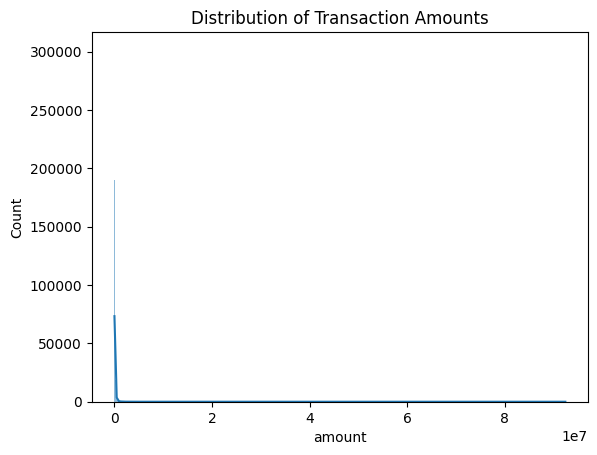

In [13]:
sns.histplot(df_cleaned['amount'], kde=True)
plt.title('Distribution of Transaction Amounts')

In [14]:
#In previous histogram shows that the amout column is heavily skewed.
# So that i used log transform makes so that amount should look normal distribution.
df_cleaned['amount_log'] = np.log1p(df_cleaned['amount'])

print("Log transform done!")

Log transform done!


Text(0.5, 1.0, 'Distribution of Log-Transformed Transaction Amounts')

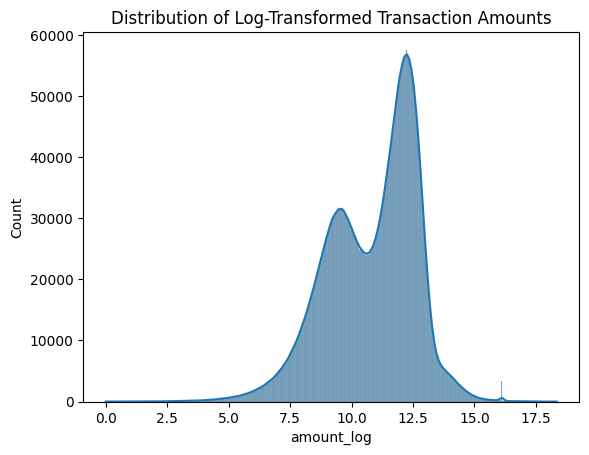

In [15]:
#after apply log transform.
sns.histplot(df_cleaned['amount_log'], kde=True)
plt.title('Distribution of Log-Transformed Transaction Amounts')

In [16]:
# Machine learning needs numbers not text
# CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER → numbers
# using one hote encoding.
df_cleaned = pd.get_dummies(df_cleaned, columns=['type'], drop_first=False)

print("Transaction type columns created:")
type_cols = [col for col in df_cleaned.columns if col.startswith('type_')]
print(type_cols)

Transaction type columns created:
['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [17]:
#Droping unecessary columnns for fast model traning.
# nameOrig and nameDest are just IDs - no predictive value
# isFlaggedFraud is a business rule not a real predictor
df_model = df_cleaned.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

print("Remaining columns for model:")
print(df_model.columns.tolist())
print("\nFinal shape:", df_model.shape)

Remaining columns for model:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isZeroAmount', 'isMerchant', 'errorBalanceOrig', 'errorBalanceDest', 'amount_log', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

Final shape: (6362620, 17)


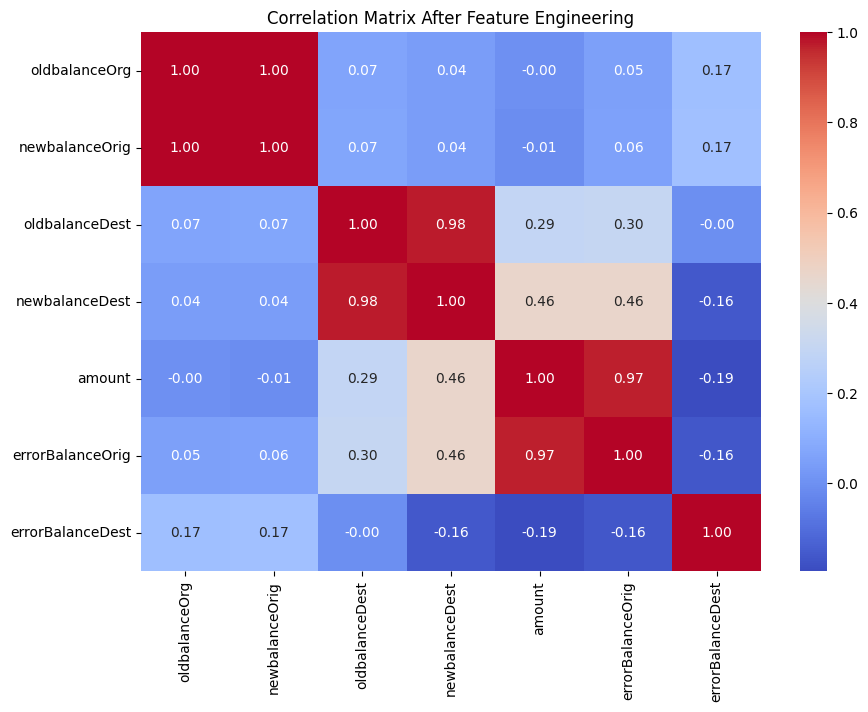

In [18]:
# Check Correlation for multicollinearity problem.
num_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
            'newbalanceDest', 'amount', 'errorBalanceOrig', 'errorBalanceDest']

corr_matrix = df_model[num_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Feature Engineering')
plt.show()

In [20]:
# oldbalanceOrg and newbalanceOrig are perfectly correlated - keep only newbalanceOrig
# oldbalanceDest and newbalanceDest are 0.98 correlated - keep only newbalanceDest
# errorBalanceOrig is 0.97 with amount - drop errorBalanceOrig, keep errorBalanceDest
# Because oldbalance not highly imact on model predection so that's why dropoed those columns

df_cleaned.drop(columns=['oldbalanceOrg', 'oldbalanceDest', 'errorBalanceOrig'], inplace=True)

print("Remaining columns:", df_cleaned.columns.tolist())

KeyError: "['oldbalanceOrg', 'oldbalanceDest', 'errorBalanceOrig'] not found in axis"

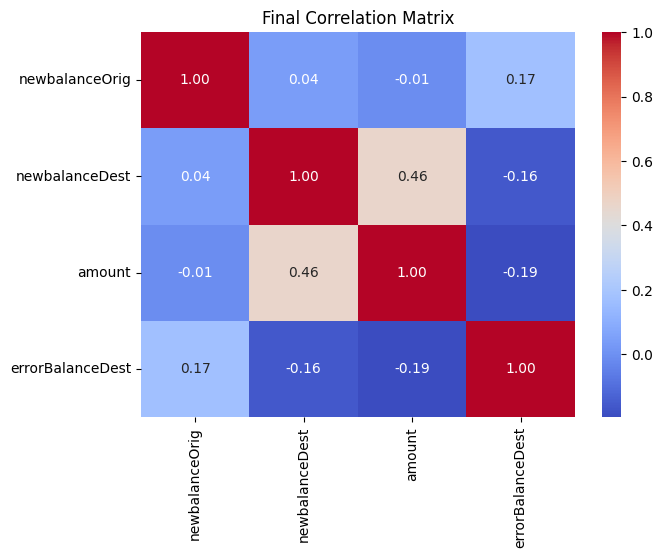

In [21]:

#Again check Correlation Matrix after dropping columns
num_cols = ['newbalanceOrig', 'newbalanceDest', 'amount', 'errorBalanceDest']

corr_matrix = df_cleaned[num_cols].corr()  #using num_cols give more control on corr

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Final Correlation Matrix')
plt.show()

In [22]:
# The 'type' column has already been converted to numbers in a previous step.
# We will now finalize df_model by dropping unnecessary columns based on previous steps.
# nameOrig, nameDest, and isFlaggedFraud were identified as having no predictive value or being business rules.
# 'oldbalanceOrg', 'oldbalanceDest', and 'errorBalanceOrig' were dropped in cell XR8pu4y1PKRB due to multicollinearity.
df_model = df_cleaned.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

print("Columns after encoding and final drops:")
print(df_model.columns.tolist())
print("\nShape:", df_model.shape)

Columns after encoding and final drops:
['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'isFraud', 'isZeroAmount', 'isMerchant', 'errorBalanceDest', 'amount_log', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

Shape: (6362620, 14)


In [23]:
# X is all [coumns]features, y is[is fraud ] what we want to predict
X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nFraud cases:", y.sum())
print("Non fraud cases:", (y == 0).sum())
print("Fraud percentage:", round(y.mean() * 100, 4), "%")

X shape: (6362620, 13)
y shape: (6362620,)

Fraud cases: 8213
Non fraud cases: 6354407
Fraud percentage: 0.1291 %


In [24]:
#Using train test split for spliting data into 80 and 20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 80% train, 20% test
    random_state=42,      # for reproducibility
    stratify=y            # keeps same fraud ratio in both splits
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("\nFraud in training:", y_train.sum())
print("Fraud in testing:", y_test.sum())

Training set size: (5090096, 13)
Testing set size: (1272524, 13)

Fraud in training: 6570
Fraud in testing: 1643


In [ ]:
#model traning section
from sklearn.ensemble import RandomForestClassifier

# class_weight balanced handles our imbalanced fraud data automatically
rf_model = RandomForestClassifier(
    n_estimators=100,          # 100 trees
    class_weight='balanced',   # handles fraud imbalance
    random_state=42,
    n_jobs=-1                  # uses all CPU cores - faster
)

print("Training started... this may take Few minutes on 6 million rows")
rf_model.fit(X_train, y_train)
print("Training complete!")

Training started... this may take 2-3 minutes on 6 million rows
Training complete!


In [ ]:
# providing test data
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Predictions done!")
print("Total predictions:", len(y_pred))
print("Predicted fraud cases:", y_pred.sum())

Predictions done!
Total predictions: 1272524
Predicted fraud cases: 1169


In [ ]:
#checking model performance.
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("=== MODEL PERFORMANCE ===\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", round(roc_auc_score(y_test, y_pred_proba), 4))

=== MODEL PERFORMANCE ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.68      0.79      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.84      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524


AUC-ROC Score: 0.9347


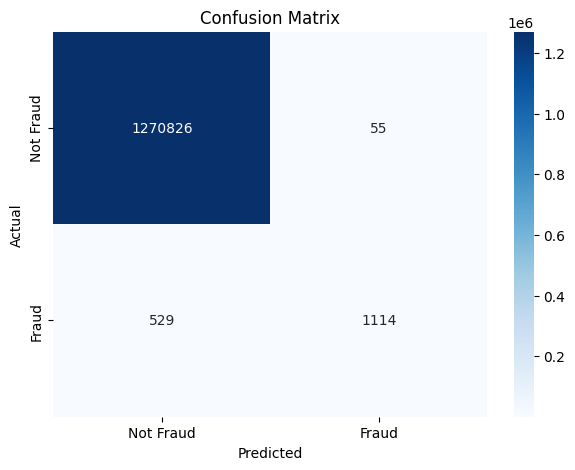


True Negatives (correctly caught non-fraud): 1270826
False Positives (legitimate flagged as fraud): 55
False Negatives (fraud missed): 529
True Positives (fraud correctly caught): 1114


In [ ]:
#ploting all the matrix.
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nTrue Negatives (correctly caught non-fraud):", cm[0][0])
print("False Positives (legitimate flagged as fraud):", cm[0][1])
print("False Negatives (fraud missed):", cm[1][0])
print("True Positives (fraud correctly caught):", cm[1][1])

/tmp/ipython-input-1543/139111601.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='Reds_r')


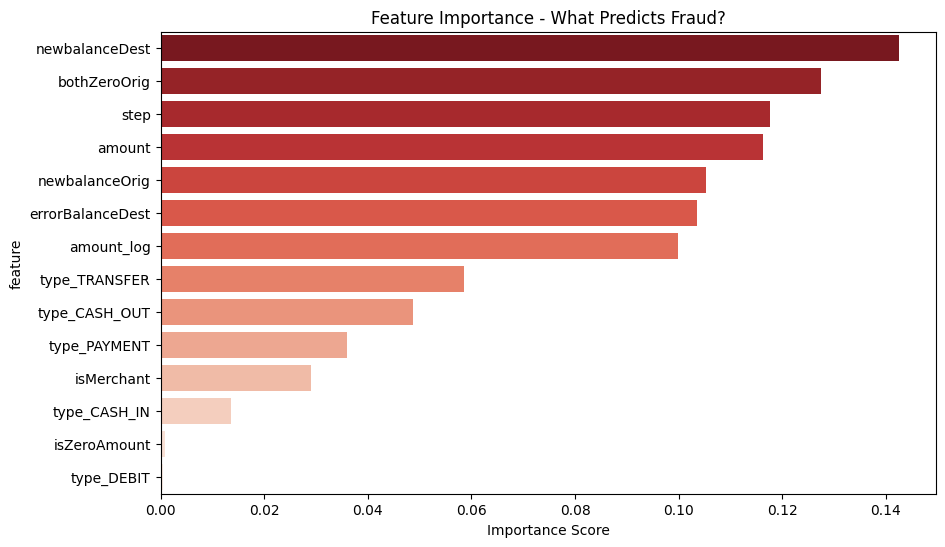


Top 5 fraud predictors:
          feature  importance
3  newbalanceDest    0.142460
6    bothZeroOrig    0.127402
0            step    0.117604
1          amount    0.116368
2  newbalanceOrig    0.105280


In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='Reds_r')
plt.title('Feature Importance - What Predicts Fraud?')
plt.xlabel('Importance Score')
plt.show()

print("\nTop 5 fraud predictors:")
print(feature_importance.head())

Outliers were detected in amount (5.31%), newbalanceOrig (16.56%)
and newbalanceDest (11.55%) using IQR method. Since these represent
real high-value transactions and deletion would cause significant
data loss, outliers were retained and handled using log transformation
on the amount column to reduce skewness while preserving all information.
Notably, amount outliers showed 1.14% fraud rate — nearly 9x higher
than the overall fraud rate of 0.13% — confirming that large
transactions are a strong fraud signal.

7. What kind of prevention should be adopted while the company updates its infrastructure?

1.Two-Step Verification for CASH_OUT and TRANSFER
Since fraud only occurs in CASH_OUT and TRANSFER transactions, these two types should have mandatory two-step verification. Similar to how Google sends a notification when someone logs in from a new device, the account holder should receive a real-time notification showing the transaction amount and destination. The transaction should only proceed after the account holder confirms it is legitimate. This ensures even if a fraudster has account access, they cannot complete the transaction without the real owner's approval.

2.Unusual Behavior Flagging
Monitor accounts for behavior that is unusual for that specific customer. For example if a customer has only ever done CASH_IN transactions and suddenly attempts a large TRANSFER or CASH_OUT, that should be automatically flagged for additional verification. Similarly accounts that have not been logged into for a long time and suddenly show transaction activity should be treated as high risk.

3.Restrict Full Balance Withdrawal
Our data showed that in the majority of fraud cases, fraudsters attempt to transfer or cash out the entire account balance in one or very few transactions. Banks should implement a rule that prevents withdrawing or transferring 100% of account balance in a single transaction or within a short time window, as legitimate customers rarely need to empty their entire account instantly.

4.Daily Transaction Limits
Set daily CASH_OUT and TRANSFER limits based on the customer's account history and typical transaction behavior. This way even if a fraudster gains access, they can only steal a limited amount before the account is flagged, significantly reducing financial losses.

5.Monitor Newly Opened Destination Accounts
Our model identified newbalanceDest as the strongest fraud predictor. Flag destination accounts that were recently opened with zero balance but are suddenly receiving large amounts from multiple different source accounts they have never transacted with before. These accounts are likely being used to collect stolen funds.

6.Deploy ML Model in Real Time
Deploy our Random Forest model as a real-time scoring system that evaluates every CASH_OUT and TRANSFER transaction before it is processed. If the fraud probability exceeds 0.3, the transaction is automatically held for review or blocked instantly.



8. Assuming these actions have been implemented, how would you determine if they work?

1.Fraud Rate Ratio Tracking
After implementation, calculate the ratio of fraud transactions to total transactions every week. If this ratio shows a dramatic decline compared to the baseline of 0.13%, the prevention measures are working and should be continued. If the decline is not significant, it indicates fraudsters have adapted and additional prevention methods need to be explored.

2.Financial Loss Comparison
Track total monetary amount lost to fraud before and after implementation. Calculate monthly loss amounts and compare them. A successful implementation should show measurable reduction in total financial losses even as overall transaction volume grows.

3.Two-Step Verification Denial Tracking
Monitor the ratio of transactions that customers actively denied during the two-step verification process — meaning the real customer confirmed it was not a genuine transaction. A high denial rate directly proves the verification system is catching real fraud attempts. This is one of the strongest indicators that the system is working effectively.

4.Limit Related Issues and Merchant Accounts
After implementing transaction limits, track customer requests to increase their limits. Pay special attention to merchant accounts since every business has different transaction needs. If too many legitimate customers are facing issues with limits, the limit rules need adjustment. For high value customers who genuinely need higher limits, consider a premium tier approach — similar to premium credit cards — where higher limits are allowed in exchange for additional security credentials and extra charges. This balances security with business needs.

5.Model Accuracy Monitoring
Regularly check the Random Forest model's performance metrics — specifically how many fraud cases it correctly detected and how many it missed. As we have now added many new prevention rules, fraudsters may shift to different patterns not seen before. Monitor new fraud cases closely to identify emerging patterns in bank statements and transaction behavior, then retrain the model with this new data to stay ahead of evolving fraud strategies. Target maintaining AUC score above 0.90 at all times.

6.False Positive Rate Monitoring
Track how many legitimate transactions are being incorrectly blocked. If too many real customers are getting flagged it damages trust and customer experience. Adjust the fraud probability threshold accordingly — if false positives are too high, raise the threshold slightly above 0.3.
Customer Complaint Tracking
Monitor customer complaints specifically related to blocked transactions, unexpected verification requests, and limit issues. A sudden increase in complaints after implementation signals that rules are too strict and need recalibration.
7.Monthly Performance Dashboard
Build a monthly report tracking all key metrics together — fraud rate ratio, total financial losses, two-step verification denial rate, limit increase requests, model AUC score, false positive rate and customer complaints. Compare every month against the pre-implementation baseline to measure overall effectiveness and identify areas needing improvement.